In [1]:
import os
import keras
import random
from keras.applications.inception_v3 import preprocess_input# import inception_v3 as inc_net
from keras.preprocessing import image
from keras.models import load_model
from skimage.io import imread
from skimage.segmentation import mark_boundaries
#from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.2.4


In [2]:
img_size = 100
data_type = 'tabak'
trained_color = "grayscale"
# felzenszwalb, slic, quickshift, watershed (<-- need to be grey)
# LIME default = slic
#superpixel_fn = "SLIC"
path_to_labels = os.path.join('labels', data_type+'.txt')
file_name = os.path.join('trainedModels',
                         data_type,
                         'completetrain',
                         'tabak_3-conv-64-nodes-0-dense-28-11-18 1306')
#file_name = "modelcatdog"

def getHighestID(preds):
    id = 0
    max = -1
    for i in range(len(preds)):
        if preds[i]>max:
            max = preds[i]
            id=i
    return id

def getLabels():
    with open(path_to_labels, 'r') as f:
     myLabels = [line.strip() for line in f]
    return myLabels

def getLabelById(id):
    with open(path_to_labels) as fp:
        for i, line in enumerate(fp):
            if i == id:
                return line.replace('\n','')
    raise Exception('ID is not in file')
    
def decode_prediction(preds):
    label_list = getLabels()    
    decoded_list = list()
    decoded_list.append([])
    for i in range(len(label_list)):
        decoded_list[0].append([label_list[i],preds[i]])
    return decoded_list

def getIdByLabel(label):
    with open(path_to_labels) as fp:
        for i, line in enumerate(fp):
            if label == line.replace('\n',''):
                return i
    raise Exception('Label is not in file')

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(img_size, img_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

def getRandomImage():
    dir_list = [x[0] for x in os.walk(os.path.join('data',data_type,'test'))][1:]
    output = list()
    only_paths = list()
    for x in dir_list:
        output.append([random.choice(os.listdir(x)),os.path.basename(x)])
        only_paths.append(os.path.join(x,random.choice(os.listdir(x))))
    return output, only_paths    




In [3]:
my_model = load_model(file_name+".h5")
print('Model loaded> '+file_name)

Model loaded> trainedModels/tabak/completetrain/tabak_3-conv-64-nodes-0-dense-28-11-18 1306


In [8]:
output, images_paths = getRandomImage()
images = transform_img_fn(images_paths)
preds = my_model.predict(images)

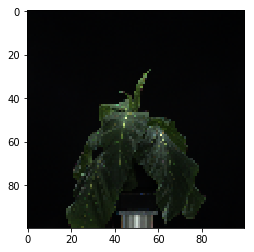

['Gut', 0.57782525]
['Schlecht', 0.4221748]
False


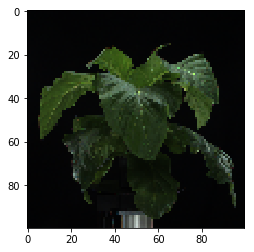

['Gut', 0.6291032]
['Schlecht', 0.3708968]
True


In [9]:
for i in range(len(images)):
    preds_with_labels = decode_prediction(preds[i])[0]
    preds_with_labels = sorted(preds_with_labels,key=lambda l:l[1], reverse=True)
    plt.figure()
    plt.imshow(images[i]/2 +0.5)
    plt.show()
    for x in preds_with_labels[:5]:
        print(x)
    isright = True if preds_with_labels[0][0] == output[i][1] else False
    print(isright)
    

In [10]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image_changed
%reload_ext autoreload

In [11]:
explainer = lime_image_changed.LimeImageExplainer()

In [22]:
%%time
import warnings
warnings.filterwarnings('ignore')
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explantions = list()
print(len(images))
#felzenszwalb, slic, quickshift,watershed
superpixel_fn ="watershed"
#TODO Parameter für Segmentation function in explain_instance übergeben 
nb_features = 1000
for image in images:
    explantions.append(explainer.explain_instance(image,
                                                  my_model.predict,
                                                  hide_color=None,
                                                  num_samples=nb_features,
                                                  segmentation_fn=superpixel_fn
                                                 ))

2
watershed
watershed
CPU times: user 43.7 s, sys: 5.71 s, total: 49.4 s
Wall time: 18.5 s


Gesund


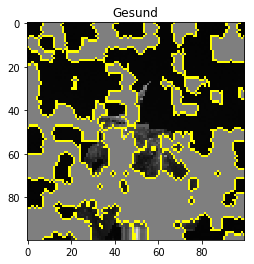

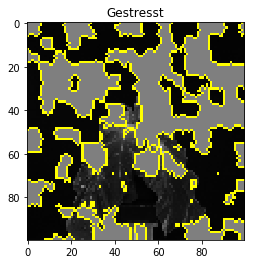

_________
Gesund


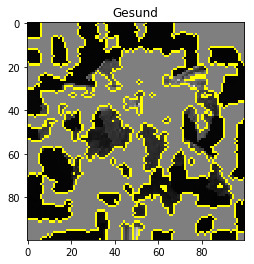

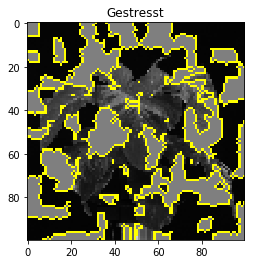

_________


In [23]:
nb_features = 500

from skimage.color import gray2rgb
for i in range(len(explantions)):
    if data_type == 'tabak' or data_type == 'catdog':
        temp, mask = explantions[i].get_image_and_mask(0,
                                                   positive_only=True,
                                                   hide_rest=True,
                                                   num_features=nb_features)
        print(getLabelById(getHighestID(preds[i])))
        plt.figure()
        plt.title(getLabelById(0))
        plt.imshow(mark_boundaries(temp/ 2 + 0.5, mask))
        plt.show()
        temp, mask = explantions[i].get_image_and_mask(1,
                                                   positive_only=True,
                                                   hide_rest=True,
                                                   num_features=nb_features)
        plt.figure()
        plt.title(getLabelById(1))
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.show()
        print("_________")        
    else:
        temp, mask = explantions[i].get_image_and_mask(getHighestID(preds[i]),
                                                   positive_only=True,
                                                   hide_rest=False,
                                                   num_features=nb_features)
        print(getLabelById(getHighestID(preds[i]))) 
        plt.figure()
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.show()